# Tutorial:   Statistics and Biomechanics  (ISB 2019, Calgary)

&copy; Todd Pataky, 2019

# Notebook 7:  Validating inferences for univariate 1D data

The purpose of this notebook is to validate probability values for univariate 1D data. This notebook requires use of the [**spm1d**](http://www.spm1d.org) package.

For brevity only the one-sample case is considered. The 1D domain is considered to be time for simplicity.

___
### Part 1:  Test statistic for one-sample univariate 1D tests

The one-sample test statistic for univariate 1D data is the same as for univariate 0D data, it is just computed at every point in time to yield a t continuum (or "trajectory", or "field").

The one-sample t statistic for 1D data is defined as:

$$ t(q) = \frac{ \overline{y(q)} - \mu(q) }{ s(q) } \sqrt{J} $$

where $q$ is continuum position.

It can be computed as follows:

In [1]:
import numpy as np
from matplotlib import pyplot
import spm1d

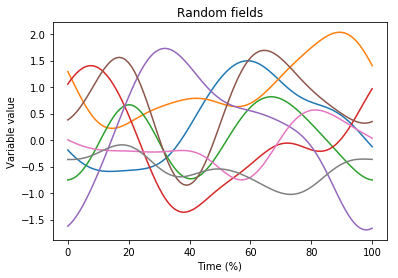

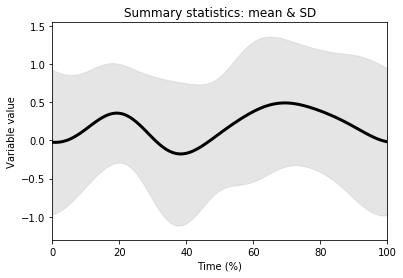

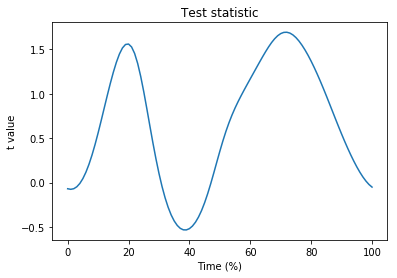

In [2]:
np.random.seed(1)
J      = 8   #sample size
Q      = 101 #number of nodes over the 1D domain
FWHM   = 25  #true sample smoothness

y      = spm1d.rft1d.randn1d(J, Q, FWHM)
t      = y.mean(axis=0) / y.std(axis=0, ddof=1) * J**0.5

# plot data:
ax     = pyplot.axes()
ax.plot(y.T)
ax.set_xlabel('Time (%)')
ax.set_ylabel('Variable value')
ax.set_title('Random fields')
pyplot.show()


# plot mean and SD:
pyplot.figure()
ax     = pyplot.axes()
spm1d.plot.plot_mean_sd(y)
ax.set_xlabel('Time (%)')
ax.set_ylabel('Variable value')
ax.set_title('Summary statistics: mean & SD')
pyplot.show()


# plot t statistic:
pyplot.figure()
ax     = pyplot.axes()
ax.plot(t)
ax.set_xlabel('Time (%)')
ax.set_ylabel('t value')
ax.set_title('Test statistic')
pyplot.show()

___
### Part 2:  Random field theory probabilities for 1D test statistic continua

[Random field theory](http://www.spm1d.org/rft1d/Theory.html) (RFT) provides probabilities for the behavior of smooth, Gaussian fields, and the most important probability is the maximum t value ($t_\textrm{max}$) across the entire domain. The maximum t value in the dataset above is:

In [3]:
tmax = t.max()

print('Maximum t value: %.5f' %tmax )

Maximum t value: 1.69300


The probability associated with this t value is given by the RFT survival function (SF):

In [4]:
nu = J - 1   #degrees of freedom
p  = spm1d.rft1d.t.sf(tmax, nu, Q, FWHM)  #theoretical

print(p)

0.3596418045245502


This p values means that there is a probability of p that the maximum t value across time, and across an infinite number of experiments, will reach a height of tmax when the true 1D mean is null (i.e., zeros across time).

The RFT inverse survival function (ISF) can be computed similarly:

In [5]:
alpha = 0.05   #Type I error rate
tstar = spm1d.rft1d.t.isf(alpha, nu, Q, FWHM)  #theoretical

print(tstar)

3.57857248407381


Note that the probability that $t_\textrm{max}$ exceeds $t^*$ is $\alpha$.

RFT provides other probabilities, and in particular probabilities associated with [suprathreshold cluster](http://www.spm1d.org/rft1d/Theory.html#upcrossings) geometry, but those probabilities are beyond the scope of these notebooks.

___
### Part 3:  Validating RFT probabilities

Similar to Notebooks 3 & 5, numerical simulations can be conducted to validate RFT probabilities. Let's validate the SF for the one-sample t test:

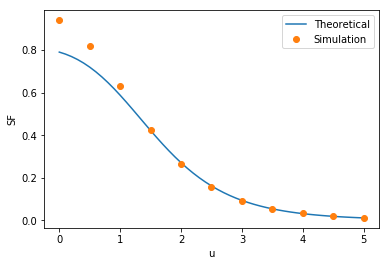

In [6]:
np.random.seed(1)
J      = 8   #sample size
Q      = 101 #number of nodes over the 1D domain
FWHM   = 25  #true sample smoothness

niter  = 10000   #number of experiments (i.e., simulation iterations)

tmax   = np.empty(niter)
for i in range(niter):
    y       = spm1d.rft1d.randn1d(J, Q, FWHM)
    t       = y.mean(axis=0) / y.std(axis=0, ddof=1) * J**0.5
    tmax[i] = t.max()
    
u0    = np.linspace(0, 5, 51)  #thresholds for the parametric (analytical) SF
u1    = np.linspace(0, 5, 11)  #thresholds for the numerical SF

df    = J-1                            #degrees of freedom
sf0   = spm1d.rft1d.t.sf(u0, nu, Q, FWHM)  #theoretical SF
sf1   = [(tmax>uu).mean() for uu in u1]  #numerical SF (from simulation)



ax = pyplot.axes()
ax.plot(u0, sf0, '-', label='Theoretical')
ax.plot(u1, sf1, 'o', label='Simulation')
ax.set_xlabel('u')
ax.set_ylabel('SF')
ax.legend()
pyplot.show()



Just like in Notebooks 3 & 5, the simulated results closely follow the theoretical ones.

However, note that the simulation results diverge from the theoretical results for low thresholds ($u<1$). RFT probabilities are only valid for relatively high thresholds, involving probabilities of about 0.4 or less. This makes RFT probabilities valid for hypothesis testing, whose rejection decisions involve much smaller probability values like $\alpha=0.05$, but generally invalid for large p values, which can be required in other forms of statistical inference like Bayesian methods.

A second issue is that the code above assumes that the FWHM is known. However, like the population mean and standard deviation, the population FWHM is usually not known, and it needs to be estimated from the data. It can be estimated using a procedure like [this one](http://www.spm1d.org/rft1d/API/geom.html?highlight=fwhm#rft1d.geom.estimate_fwhm), which implements the approach of [Kiebel et al. (1999)](https://doi.org/10.1006/nimg.1999.0508).

Validating RFT probabilities for other sample sizes, and validating RFT's ISF are left for optional work. You may wish to consult [these example scripts](http://www.spm1d.org/rft1d/Examples.html), which provide extensive numerical validation of various RFT probabilities involving: arbitrary data sizes, arbitrary experimental designs, multivariate 1D data, etc.

___
### Summary

This notebook has shown that:
* Univariate tests like the one-sample t test can be applied directly to 1D data using RFT probabilities.
* The most important probability for 1D hypothesis testing it the probability that the maximum test statistic value reaches a particular height
* Like 0D data, 1D data can be simulated to validate probability values, and more generally to quantify the expected behavior of random data over a large number of experiments